# Introduction
This notebook is based on 
1. [2.5d segmentaion baseline [training]](https://www.kaggle.com/code/tanakar/2-5d-segmentaion-baseline-training)
2. [2.5d segmentaion baseline [inference]](https://www.kaggle.com/code/tanakar/2-5d-segmentaion-baseline-inference)
3. [Vesuvius Challenge - 3D ResNet Training](https://www.kaggle.com/code/samfc10/vesuvius-challenge-3d-resnet-training)
4. [Improving performance with L1/Hessian denoising](https://www.kaggle.com/code/brettolsen/improving-performance-with-l1-hessian-denoising)

Thank them for letting us learn more.(^w^)

Base parameter:
1. ResNet34
2. 1fold only!! (Use 2,3 to train and 1 to val)
3. use 16 channels
4. loss = 0.5 * BCELoss + 0.5 * DiceLoss

then get cv0.55 (^w^)


In [114]:
import os,cv2
import gc
import sys
import random
from glob import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

ROOT_DIR = "/home/fummicc1/codes/Kaggle/kaggle-ink-detection"

sys.path.append(ROOT_DIR)
# sys.path.append("/kaggle/input/resnet3d")
from resnet3d import generate_model
import torch as tc


def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [115]:
class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    comp_dir_path = '/home/fummicc1/codes/competitions/kaggle-ink-detection'
    # comp_dir_path = '/home/fummicc1/codes/Kaggle/kaggle-ink-detection/'    
    # comp_dir_path = '/kaggle/input/'
    comp_folder_name = ''
    # comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    #backbone = 'efficientnet-b5'
    #backbone = 'mit_b5'
    backbone = 'resnet3d'
    #backbone = 'resnext50_32x4d'
    pretrained = True

    in_chans = 16 # 65
    load_chans=16
    # ============== training cfg =============
    prd_size=192
    stride = prd_size // 8

    batch_size = 96 # 32
    use_amp = True

    seed = 42
    num_workers=8
    
    mode = "train"

    device_ids=[0, 1, 2, 3]

    lr = 1e-3
    epochs = 10

    TH = 0.75
    exp = 1e-6

    TTA = False

## helper

In [116]:
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    # pixels = (pixels >= thr).astype(int)
    
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
def normalization(x:tc.Tensor)->tc.Tensor:
    """input.shape=(batch,f1,f2,...)"""
    #[batch,f1,f2]->dim[1,2]
    dim=list(range(1,x.ndim))
    mean=x.mean(dim=dim,keepdim=True)
    std=x.std(dim=dim,keepdim=True)
    return (x-mean)/(std+1e-9)

def get_folder_size(folder_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size

In [117]:
set_seed(CFG.seed)

In [118]:
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    # pixels = (pixels >= thr).astype(int)
    
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
def normalization(x:tc.Tensor)->tc.Tensor:
    """input.shape=(batch,f1,f2,...)"""
    #[batch,f1,f2]->dim[1,2]
    dim=list(range(1,x.ndim))
    mean=x.mean(dim=dim,keepdim=True)
    std=x.std(dim=dim,keepdim=True)
    return (x-mean)/(std+1e-9)

def get_folder_size(folder_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size

## dataset

In [119]:
def read_image(mode, fragment_id):
    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        image = cv2.imread(CFG.comp_dataset_path + f"{mode}/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.prd_size - image.shape[0] % CFG.prd_size)
        pad1 = (CFG.prd_size - image.shape[1] % CFG.prd_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)
    
    return images

In [120]:
class NormalizeTransform(A.ImageOnlyTransform):
    def __init__(self, always_apply=False, p=1.0):
        super(NormalizeTransform, self).__init__(always_apply, p)

    def apply(self, img, **params):
        # median = np.full_like(img, all_median).astype(np.float32)
        # mad = np.full_like(img, all_MAD).astype(np.float32)
        # img = (img - median) / mad
        # img = img / median
        img = img / 255
        img = (img - 0.45) / 0.225
        # img[img < 0] = 0
        return img

class CustomDataset(Dataset):
    def __init__(self, images, cfg,xys, labels=None, transform: bool = False):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.xys=xys
        self.transform = transform

    def __len__(self):
        # return len(self.xyxys)
        return len(self.images)

    def __getitem__(self, idx):
        BUFFER = CFG.prd_size // 2
        location = np.array(self.xys[idx])
        image: np.ndarray = self.images[idx]
        label = None
        if self.labels is not None:
            label = self.labels[idx]
            label = np.stack([label], axis=-1)
        if self.transform and label is not None:
            size = int(CFG.prd_size)
            # print("label", label.shape, "image", image.shape)
            performed = A.Compose([
                NormalizeTransform(always_apply=True),
                A.HorizontalFlip(p=0.5), # 水平方向に反転
                A.VerticalFlip(p=0.5), # 水平方向に反転
                A.RandomRotate90(p=0.5),
                A.ShiftScaleRotate(p=0.5, border_mode=0), # シフト、スケーリング、回転
                A.RandomCrop(height=int(size / 1.25), width=int(size / 1.25), p=0.5), # ランダムにクロップ, Moduleの中で計算する際に次元がバッチ内で揃っている必要があるので最後にサイズは揃える
                A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
                A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                                mask_fill_value=0, p=0.2),
                A.OneOf([
                    A.GaussianBlur(blur_limit=(3, 5)),
                    A.MotionBlur(blur_limit=5, p=1),
                ], p=1),
                A.Resize(BUFFER * 2, BUFFER * 2, always_apply=True),                                          
                ToTensorV2(transpose_mask=True),                
            ])(image=image, mask=label)            
            image = performed["image"]
            label = performed["mask"]            
        else:
            if label is None:
                performed = A.Compose([                                
                    NormalizeTransform(always_apply=True),
                    ToTensorV2(transpose_mask=True),
                ])(image=image)
                image = performed["image"]
                return image, location
            else:
                # print("image in val dataset (before aug)", image, file=open("before-val-aug.log", "w")) 
                performed = A.Compose([
                    NormalizeTransform(always_apply=True),
                    ToTensorV2(transpose_mask=True),
                ])(image=image, mask=label)                
                label = performed["mask"]                
                image = performed["image"]
            
        return image, label


In [121]:
def make_dataset(fragment_id, is_train_data):
    images = read_image(CFG.mode, fragment_id)
    mask_path = os.path.join(CFG.comp_dataset_path, f"{CFG.mode}/{fragment_id}/mask.png")
    label_path = os.path.join(CFG.comp_dataset_path, f"{CFG.mode}/{fragment_id}/inklabels.png")
    if os.path.exists(label_path):
        labels = cv2.imread(label_path, 0) / 255
    else:
        labels = None
    mask = cv2.imread(mask_path, 0) / 255
    pad0 = (CFG.prd_size - mask.shape[0] % CFG.prd_size)
    pad1 = (CFG.prd_size - mask.shape[1] % CFG.prd_size)

    if labels is not None:
        labels = np.pad(labels, [(0, pad0), (0, pad1)], constant_values=0)
    
    x1_list = list(range(0, images.shape[1]-CFG.prd_size+1, CFG.stride))
    y1_list = list(range(0, images.shape[0]-CFG.prd_size+1, CFG.stride))
    
    images_list = []
    labels_list = []
    xyxys = []
    for y1 in y1_list:
        for x1 in x1_list:
            y2 = y1 + CFG.prd_size
            x2 = x1 + CFG.prd_size
            if np.all(images[y1:y2, x1:x2]==0):
                continue
            if labels is not None:
                labels_list.append(labels[y1:y2, x1:x2])
            images_list.append(images[y1:y2, x1:x2])
            xyxys.append((x1, y1, x2, y2))
    print("hello")
    xyxys = np.stack(xyxys)

    ds = CustomDataset(images_list, CFG,xys=xyxys, labels=labels_list if labels_list else None, transform=is_train_data)
    
    loader = DataLoader(
        ds,
        batch_size=CFG.batch_size,
        shuffle=is_train_data,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=False,
        persistent_workers=True
    )
    
    return loader, xyxys

## 3D ResNet

In [122]:
class Decoder(nn.Module):
    def __init__(self, encoder_dims, upscale):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(encoder_dims[i]+encoder_dims[i-1], encoder_dims[i-1], 3, 1, 1, bias=False),
                nn.BatchNorm2d(encoder_dims[i-1]),
                nn.ReLU(inplace=True)
            ) for i in range(1, len(encoder_dims))])

        self.logit = nn.Conv2d(encoder_dims[0], 1, 1, 1, 0)
        self.up = nn.Upsample(scale_factor=upscale, mode="bilinear")

    def forward(self, feature_maps):
        for i in range(len(feature_maps)-1, 0, -1):
            f_up = F.interpolate(feature_maps[i], scale_factor=2, mode="bilinear")
            f = torch.cat([feature_maps[i-1], f_up], dim=1)
            f_down = self.convs[i-1](f)
            feature_maps[i-1] = f_down

        x = self.logit(feature_maps[0])
        mask = self.up(x)
        return mask
    
class SegModel(nn.Module):
    def __init__(self,model_depth=18):
        super().__init__()
        self.encoder = generate_model(model_depth=model_depth, n_input_channels=1)
        self.decoder = Decoder(encoder_dims=[64, 128, 256, 512], upscale=4)
        
    def forward(self, x):
        if x.ndim==4:
            x=x[:,None] # チャネルを追加
        
        feat_maps = self.encoder(x)
        feat_maps_pooled = [torch.mean(f, dim=2) for f in feat_maps]
        pred_mask = self.decoder(feat_maps_pooled)
        return pred_mask
        
class CustomModel(nn.Module):
    def __init__(self, cfg=CFG, weight=None):
        super().__init__()
        self.cfg = cfg

        if cfg.backbone=="resnet3d":
            self.encoder=SegModel()
        elif cfg.backbone[:3]!="mit":
            self.encoder = smp.Unet(
                encoder_name=cfg.backbone, 
                encoder_weights=weight,
                in_channels=cfg.in_chans,
                classes=cfg.target_size,
                activation=None,
            )
        else :
            self.encoder = smp.Unet(
                encoder_name=cfg.backbone, 
                encoder_weights=weight,
                classes=cfg.target_size,
                activation=None,
            )
            print("self.encoder.encoder.patch_embed1.proj", self.encoder.encoder.patch_embed1.proj)
            out_channels=self.encoder.encoder.patch_embed1.proj.out_channels
            self.encoder.encoder.patch_embed1.proj=nn.Conv2d(cfg.in_chans,out_channels,7,4,3)

    def forward(self, images:torch.Tensor):
        #image.shape=(b,C,H,W)
        if images.ndim==4:
            images=images[:,None]
        # images=normalization(images)
        output = self.encoder(images)
        return output

def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)
    return model


In [123]:
def TTA(x:tc.Tensor,model:nn.Module):
    #x.shape=(batch,c,h,w)
    shape=x.shape
    x=[x,*[tc.rot90(x,k=i,dims=(-2,-1)) for i in range(1,4)]]
    x=tc.cat(x,dim=0)
    x=model(x)
    x=torch.sigmoid(x)
    x=x.reshape(4,shape[0],*shape[2:])
    x=[tc.rot90(x[i],k=-i,dims=(-2,-1)) for i in range(4)]
    x=tc.stack(x,dim=0)
    return x.mean(0)

In [124]:
#in_submission=get_folder_size("/kaggle/input/vesuvius-challenge-ink-detection/test")!=6732244267
in_submission=True
IS_DEBUG = False
CFG.mode = 'train' if IS_DEBUG else 'test'

TH = CFG.TH
if CFG.mode == 'test':
    fragment_ids = sorted(os.listdir(CFG.comp_dataset_path + CFG.mode))
else:
    fragment_ids = [3]

predictions_map = None
predictions_map_counts = None
pad0 = None
pad1 = None
ori_h = None
ori_w = None

100%|██████████| 16/16 [00:00<00:00, 40.15it/s]


hello


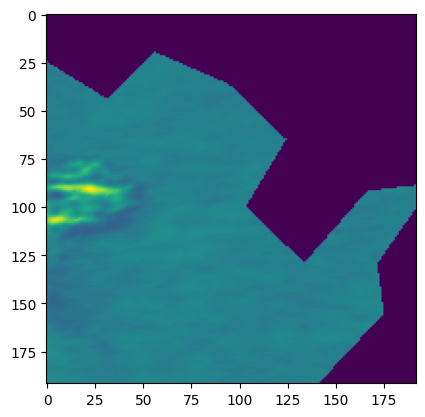

In [125]:
lodaer, _ = make_dataset("a", is_train_data=False)
img, _ = lodaer.dataset[100]
plt.imshow(img[1, :, :])

In [126]:
class Model(pl.LightningModule):
    
    training_step_outputs = []
    validation_step_outputs = []
    test_step_outputs = [[], []]

    def __init__(self):
        super().__init__()

        model = build_model(CFG)        
        
        self.model = model

        self.segmentation_loss_fn = smp.losses.TverskyLoss(
            smp.losses.BINARY_MODE,
            log_loss=False,
            from_logits=True,
            smooth=1e-6,
        )

    def forward(self, image):
        # normalize image here
        # image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):        
        images, labels = batch
        images, labels = images.float(), labels.float()
        assert images.ndim == 4
        h, w = images.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        assert labels.ndim == 4

        assert labels.max() <= 1.0 and labels.min() >= 0

        # print("labels.shape", labels.shape[2:], "images.shape", images.shape[2:])

        assert labels.shape[2] == images.shape[2] and labels.shape[3] == images.shape[3]

        segmentation_out = self.forward(images)
        
        segmentation_out = segmentation_out.sigmoid()
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.segmentation_loss_fn(segmentation_out, labels)

        prob_mask = segmentation_out 
        pred_mask = (prob_mask > TH).float()

        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), labels.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])
        loss = torch.mean(torch.Tensor([x["loss"] for x in outputs]))

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")        
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
            f"{stage}_loss": loss,
            f"{stage}_tp": tp.sum().item(),
            f"{stage}_fp": fp.sum().item(),
            f"{stage}_fn": fn.sum().item(),
            f"{stage}_tn": tn.sum().item(),
        }
        
        self.log_dict(metrics, prog_bar=True, sync_dist=True)

    def training_step(self, batch, batch_idx):
        out = self.shared_step(batch, "train")
        self.training_step_outputs.append(out)
        return out

    def on_train_epoch_end(self):
        out = self.shared_epoch_end(self.training_step_outputs, "train")
        self.training_step_outputs.clear()
        return out

    def validation_step(self, batch, batch_idx):
        out = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(out)        
        return out

    def on_validation_epoch_end(self):
        out = self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return out

    def test_step(self, batch, batch_idx):
        global predictions_map, predictions_map_counts

        patch_batch, loc_batch = batch
        
        loc_batch = loc_batch.long()
        patch_batch = patch_batch.float()
        predictions: torch.Tensor = self.forward(patch_batch)
        # print("predictions.shape", predictions.shape)
        # print("predictions", predictions)        
        predictions = predictions.sigmoid()
        # print("Softmaxed predictions where conf is gt threshold", predictions[predictions.gt(threshold)])
        # print("predictions.shape after sigmoid", predictions.shape)
        # →(BATCH, W, H, C)
        predictions = torch.permute(predictions, (0, 3, 2, 1))
        predictions = predictions.squeeze(dim=-1)
        # print("prediction shape", predictions.shape)
        predictions = predictions.cpu().numpy()  # move predictions to cpu and convert to numpy
        loc_batch = loc_batch.cpu().numpy()
        # print("predictions_map", predictions_map)
        # print("predictions_map_count", predictions_map_counts)
        self.test_step_outputs[0].extend(loc_batch)
        self.test_step_outputs[1].extend(predictions)
        return loc_batch, predictions

    def on_test_epoch_end(self):
        global predictions_map, predictions_map_counts        
        BUFFER = CFG.prd_size // 2
        exp = CFG.exp
        
        locs = np.array(self.test_step_outputs[0])
        preds = np.array(self.test_step_outputs[1])
        print("locs", locs.shape)
        print("preds", preds.shape)
        
        new_predictions_map = np.zeros_like(predictions_map[:, :, 0])
        new_predictions_map_counts = np.zeros_like(predictions_map_counts[:, :, 0])
        
        for (x1, y1, x2, y2), pred in zip(locs, preds):            
            new_predictions_map[
                y1 : y2, x1 : x2
            ] += pred
            new_predictions_map_counts[y1 : y2, x1 : x2] += 1
        new_predictions_map /= (new_predictions_map_counts + exp)        
        new_predictions_map = new_predictions_map[:, :, np.newaxis]
        new_predictions_map_counts = new_predictions_map_counts[:, :, np.newaxis]
        predictions_map = np.concatenate([predictions_map, new_predictions_map], axis=-1)
        predictions_map_counts = np.concatenate([predictions_map_counts, new_predictions_map_counts], axis=-1)
        print("new_predictions_map", new_predictions_map.shape)
        print("predictions_map", predictions_map.shape)

    def configure_optimizers(self):
        lr = CFG.lr
        optimizer = optim.Adam(self.parameters(), lr=lr)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.05, patience=5, min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": { "scheduler": scheduler, "monitor": "valid_loss" }}


## main

100%|██████████| 16/16 [00:00<00:00, 43.24it/s]


hello


/tmp/ipykernel_194587/3191046597.py:19: RuntimeWarning: invalid value encountered in cast
  predictions_map_counts = np.empty_like(predictions_map).astype(np.uint8)


model_name Unet
backbone resnet3d


/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/ ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should 

Testing: 0it [00:00, ?it/s]

locs (21042, 4)
preds (21042, 192, 192)
new_predictions_map (2880, 6336, 1)
predictions_map (2880, 6336, 2)
predictions_map_counts.shape (2880, 6336)


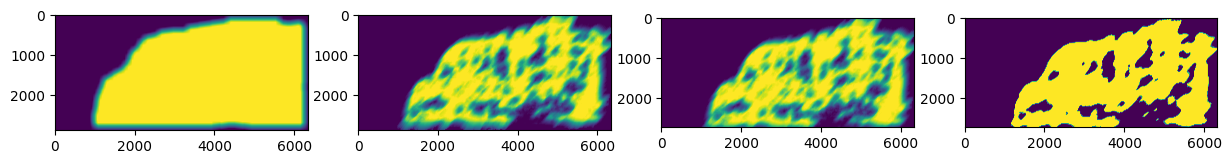

100%|██████████| 16/16 [00:00<00:00, 18.22it/s]


hello
model_name Unet
backbone resnet3d


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

locs (55703, 4)
preds (55703, 192, 192)
new_predictions_map (5568, 6336, 1)
predictions_map (5568, 6336, 2)
predictions_map_counts.shape (5568, 6336)


<Figure size 640x480 with 0 Axes>

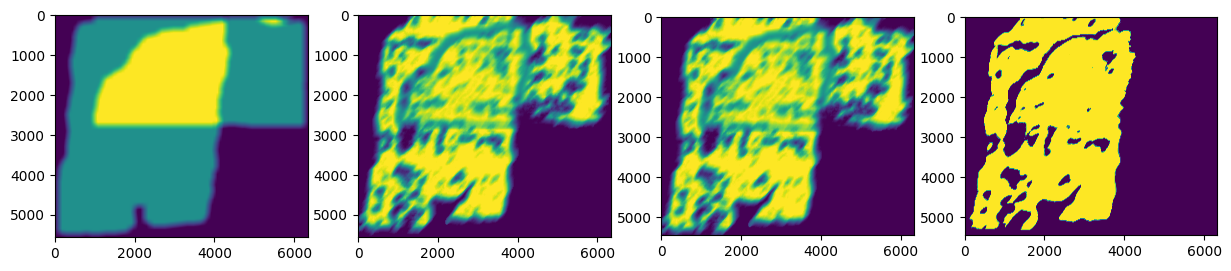

<Figure size 640x480 with 0 Axes>

In [127]:
results = []
for fragment_id in fragment_ids:
    if not in_submission:
        break
    test_loader, xyxys = make_dataset(fragment_id, is_train_data=False)
    
    binary_mask = cv2.imread(CFG.comp_dataset_path + f"{CFG.mode}/{fragment_id}/mask.png", 0)
    binary_mask = (binary_mask / 255).astype(int)
    
    ori_h = binary_mask.shape[0]
    ori_w = binary_mask.shape[1]

    pad0 = (CFG.prd_size - binary_mask.shape[0] % CFG.prd_size)
    pad1 = (CFG.prd_size - binary_mask.shape[1] % CFG.prd_size)

    binary_mask = np.pad(binary_mask, [(0, pad0), (0, pad1)], constant_values=0)

    predictions_map = np.empty_like(binary_mask)[:, :, np.newaxis].astype(np.float64)
    predictions_map_counts = np.empty_like(predictions_map).astype(np.uint8)

    model = Model.load_from_checkpoint(
        f"weights/weights.ckpt",
        # f"/kaggle/input/first-ink-detection/weights_fold-{fold}.ckpt",
    )

    trainer = pl.Trainer(
        accelerator="gpu",
        devices="1",
        max_epochs=CFG.epochs,
        logger=WandbLogger()
    )

    trainer.test(
        model=model,
        dataloaders=test_loader,
        verbose=True,
    )

    
    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    
    # TODO: Kfold
    # predictions_mapやpredictions_map_countsは0番目のチャネルには適用な値が入っているので注意

    predictions_map = predictions_map[:, :, 1:].mean(axis=-1)
    predictions_map_counts = predictions_map_counts[:, :, 1:].mean(axis=-1)
    print("predictions_map_counts.shape", predictions_map_counts.shape)    

    axes[0].imshow(predictions_map_counts)
    axes[1].imshow(predictions_map)  

    mask_pred = predictions_map[:ori_h, :ori_w]
    binary_mask = binary_mask[:ori_h, :ori_w]

    axes[2].imshow(mask_pred)
    
    mask_pred = (mask_pred >= TH).astype(np.uint8)
    mask_pred=mask_pred.astype(int)
    mask_pred *= binary_mask
    
    axes[3].imshow(mask_pred)
    plt.show()
    
    inklabels_rle = rle(mask_pred)
    
    results.append((fragment_id, inklabels_rle))
    

    del predictions_map, predictions_map_counts
    del test_loader
    
    gc.collect()
    torch.cuda.empty_cache()
    plt.clf()
    plt.close(fig)

## submission

In [128]:
! cp /kaggle/input/vesuvius-challenge-ink-detection/sample_submission.csv submission.csv
if in_submission:
    sub = pd.DataFrame(results, columns=['Id', 'Predicted'])
    #sub
    sample_sub = pd.read_csv(CFG.comp_dataset_path + 'sample_submission.csv')
    sample_sub = pd.merge(sample_sub[['Id']], sub, on='Id', how='left')
    #sample_sub
    sample_sub.to_csv("submission.csv", index=False)
    print("ok")

/bin/bash: /home/fummicc1/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
cp: '/kaggle/input/vesuvius-challenge-ink-detection/sample_submission.csv' を stat できません: そのようなファイルやディレクトリはありません
ok
